In [0]:
"""

Research goals:

Visualizations:
- Single Component Contribution - visualize what it would look like if a only a single component was propagated through the network with everything else zeroed out
- Ablation Study of Encoding - Start with a single component, and keep un-zero-ing other components till the entire encoding is recovered
- Component Impact Distribution - Understand which components are important for which types/classes of samples 

"""

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model

# Network

encoding_length = 10

# Encoder
input_img = Input(shape = (28, 28, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 14 x 14 x 32
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # 7 x 7 x 64
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128
flat = Flatten()(conv3) # 6272
fc1 = Dense(784)(flat)
encoded = Dense(encoding_length)(fc1)
encoder = Model(input_img, encoded)

# Decoder
input_encoded = Input(shape=(encoding_length,))
fc2 = Dense(784)(input_encoded)
fc3 = Dense(6272)(fc2)
unflat = Reshape((7, 7, 128))(fc3)
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(unflat) #7 x 7 x 128
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
decoder = Model(input_encoded, decoded)

# Full model
autoencoder = Model(input_img, decoder(encoded))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

print(autoencoder.summary())

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000,)
(10000,)


In [3]:
history = autoencoder.fit(x_train, x_train,
                          epochs=10,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 357us/step - loss: 0.2498 - val_loss: 0.1707
Epoch 2/10
60000/60000 [==============================] - 18s 303us/step - loss: 0.1578 - val_loss: 0.1368
Epoch 3/10
60000/60000 [==============================] - 18s 302us/step - loss: 0.1366 - val_loss: 0.1304
Epoch 4/10
60000/60000 [==============================] - 18s 302us/step - loss: 0.1289 - val_loss: 0.1218
Epoch 5/10
60000/60000 [==============================] - 18s 304us/step - loss: 0.1241 - val_loss: 0.1211
Epoch 6/10
60000/60000 [==============================] - 18s 303us/step - loss: 0.1209 - val_loss: 0.1224
Epoch 7/10
60000/60000 [==============================] - 18s 302us/step - loss: 0.1181 - val_loss: 0.1187
Epoch 8/10
60000/60000 [==============================] - 18s 301us/step - loss: 0.1162 - val_loss: 0.1140
Epoch 9/10
60000/60000 [==============================] - 18s 302us/step - loss: 0.1146 - val_

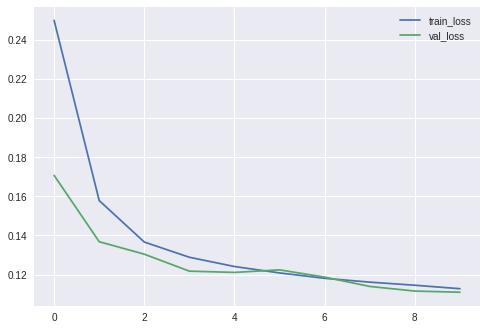

In [4]:
# Plot loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss)
plt.plot(val_loss)
plt.gca().legend(('train_loss','val_loss'))

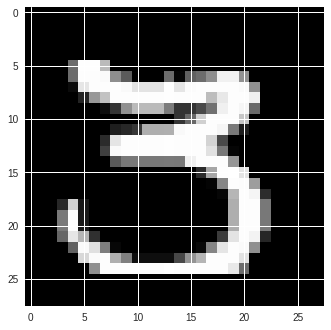

In [5]:
# Visualize Random Image
rand_img = x_test[np.random.randint(len(x_test))]
plt.imshow(rand_img[:, :, 0], cmap='gray')

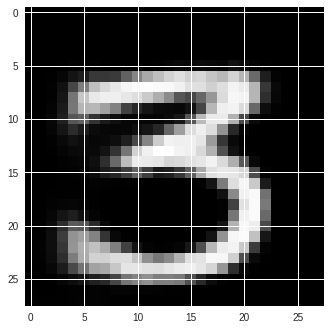

In [6]:
# Run it through encoder
rand_decoded = autoencoder.predict(np.expand_dims(rand_img, axis=0))
plt.imshow(rand_decoded[0][:, :, 0], cmap='gray')

In [8]:
# Look at encoded vector

rand_encoding = encoder.predict(np.expand_dims(rand_img, axis=0))
print(rand_encoding[0])

[-7.918853   2.9432988 -6.47459   -6.087154  -1.4155438  2.5796072
 -2.5548606 -8.997441  -3.332086  -2.770016 ]


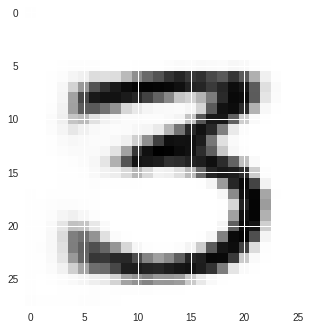

In [9]:
# Run encoded vector through decoder

rand_decoding = decoder.predict(rand_encoding)
plt.imshow(rand_decoding[0][:,:,0])

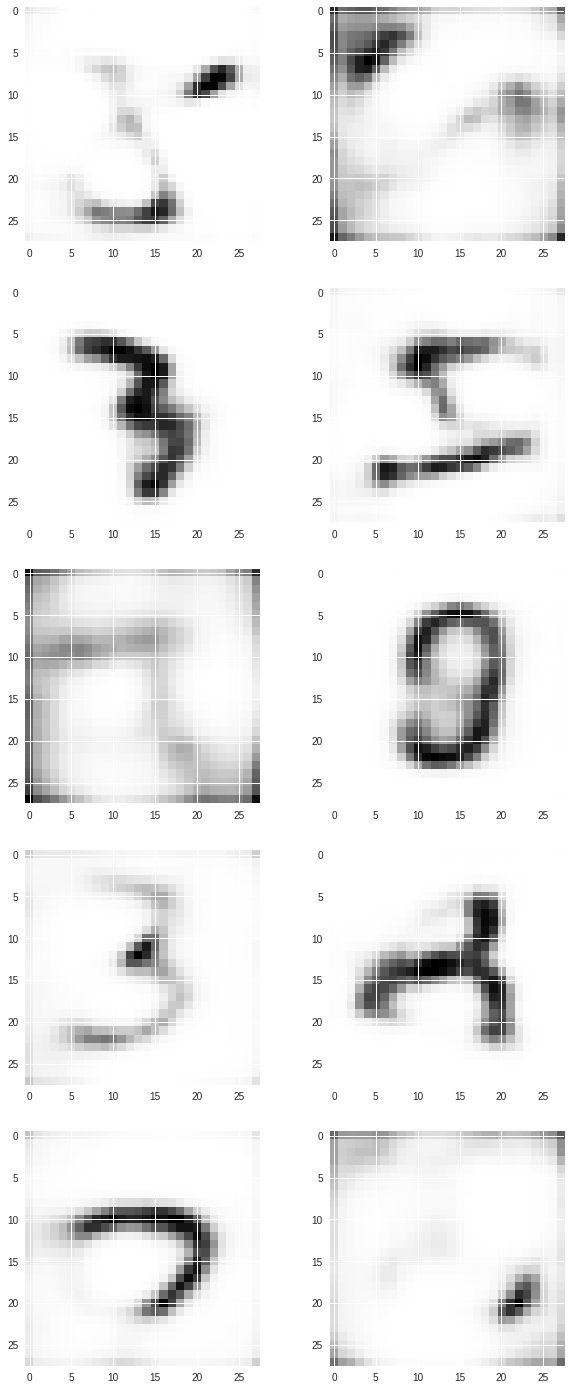

In [15]:
# Zero out pixels one by one and display the outputs

fig = plt.figure()
encoding_length = 10

for i in range(encoding_length):
  
  # Get output
  mask = np.zeros(encoding_length)
  mask[i] = 1 # make a single value non-zero
  masked = np.multiply(rand_encoding, mask)
  decoded_masked = decoder.predict(masked)
  
  # Plot
  fig.add_subplot(encoding_length / 2, 2, i + 1)
  plt.imshow(decoded_masked[0][:,:,0])

scale_factor = 5
fig.set_size_inches(scale_factor * 2, scale_factor * encoding_length / 2)

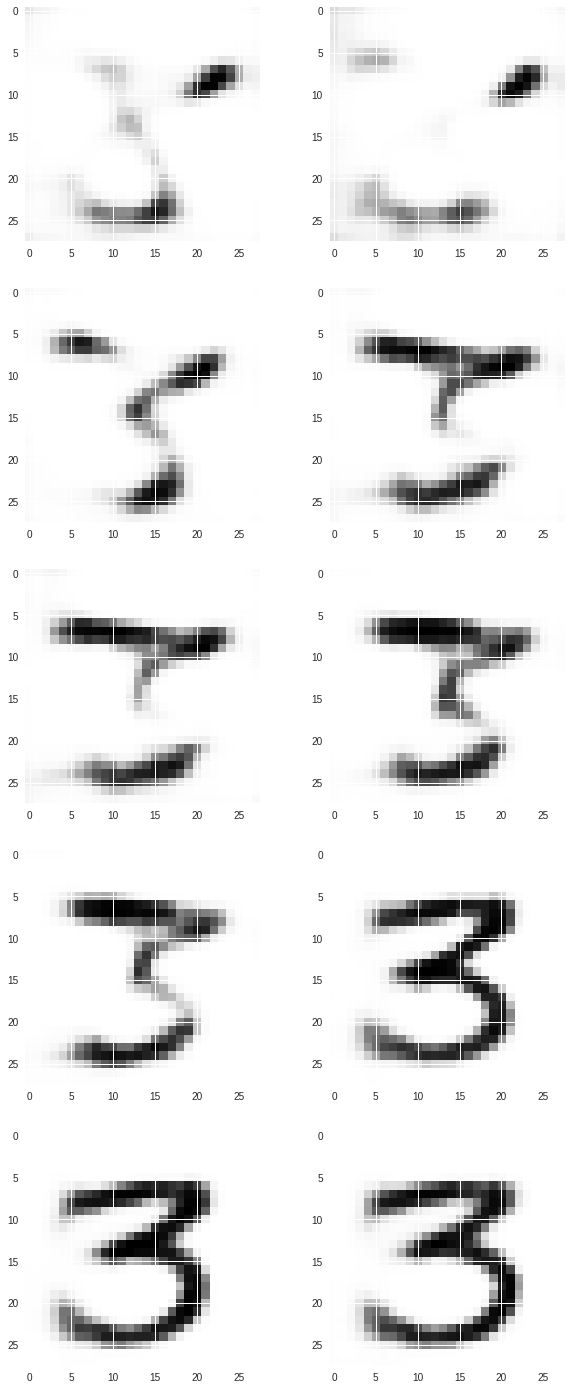

In [16]:
# "Ablation" Study of components

fig = plt.figure()

encoding_length = 10
mask = np.zeros(encoding_length)

for i in range(encoding_length):
  
  # Get output
  mask[i] = 1 # make a single value non-zero
  masked = np.multiply(rand_encoding, mask)
  decoded_masked = decoder.predict(masked)
  
  # Plot
  fig.add_subplot(encoding_length / 2, 2, i + 1)
  plt.imshow(decoded_masked[0][:,:,0])

scale_factor = 5
fig.set_size_inches(scale_factor * 2, scale_factor * encoding_length / 2)

In [17]:
# Visualize which components contribute to which classes
# Goal is to create a confusion matrix with the x-axis being the different classes
# and the y-axis showing which component was zeroed-out.
# The value of of the confusion matrix at (x,y) is the aggregate error of all
# samples of class x where the y-th component of the encoding was zerooed out.

encoding_length = 10
classes = np.unique(y_test)
error_data = np.zeros((encoding_length, len(classes)))

for j, c in enumerate(classes):
  class_indices = np.where(y_test == c)[0]
  class_samples = x_test[class_indices]
  class_encoding = encoder.predict(class_samples)
  
  # Zero out a single component and see loss
  for i in range(encoding_length):
    
    mask = np.ones(encoding_length)
    mask[i] = 0 # make a single value zero
    masked = np.multiply(class_encoding, mask)
    class_decoding = decoder.predict(masked)
    
    # Calculate error between expected
    error = np.mean((class_samples - class_decoding) ** 2)
    error_data[i][j] = error
    
  print("Completed Class: " + str(c))

Completed Class: 0
Completed Class: 1
Completed Class: 2
Completed Class: 3
Completed Class: 4
Completed Class: 5
Completed Class: 6
Completed Class: 7
Completed Class: 8
Completed Class: 9


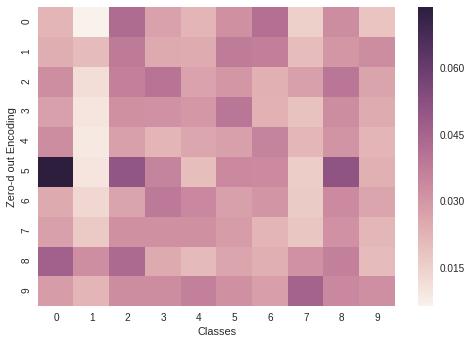

In [18]:
# Plot confusion matrix
import seaborn as sns
ax = sns.heatmap(error_data)
ax.set(xlabel='Classes', ylabel='Zero-d out Encoding')
plt.show()